In [1]:
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data
import config
import network

In [2]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')

In [3]:
rand_sub_bval_indice_100206 = np.array(process_data.get_rand_selected_bval_indice(bvals_all_100206, 6))

In [2]:
rand_sub_bval_indice_100206 = [  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
       220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245,
       246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258,
       259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271]

In [3]:
normalized_scan_100206_full = np.load(config.norm_data_path + '/normalized_scan_100206_full.npy')

In [4]:
normalized_scan_100610_full = np.load('normalized_scan_100610_full.npy')

In [5]:
bvals_all_100206 = np.loadtxt(config.data_folder2 + '/100206/bvals')
bvals_all_100610 = np.loadtxt(config.data_folder2 + '/100610/bvals')

In [6]:
bvals_100206_sub = bvals_all_100206[rand_sub_bval_indice_100206]*1e-3
bvals_100610_sub = bvals_all_100610[rand_sub_bval_indice_100206]*1e-3

In [7]:
normalized_scan_100206_sub = normalized_scan_100206_full[:, rand_sub_bval_indice_100206]
normalized_scan_100610_sub = normalized_scan_100610_full[:, rand_sub_bval_indice_100206]

In [8]:
big_b_indice_100206_sub = np.where(bvals_100206_sub != 0.005)[0]
big_b_indice_100610_sub = np.where(bvals_100610_sub != 0.005)[0]

In [9]:
bvals_100206_sub_no_b5 = bvals_100206_sub[big_b_indice_100206_sub]
bvals_100610_sub_no_b5 = bvals_100610_sub[big_b_indice_100610_sub]

In [10]:
normalized_scan_100206_sub_no_b5 = normalized_scan_100206_sub[:, big_b_indice_100206_sub]
normalized_scan_100610_sub_no_b5 = normalized_scan_100610_sub[:, big_b_indice_100610_sub]

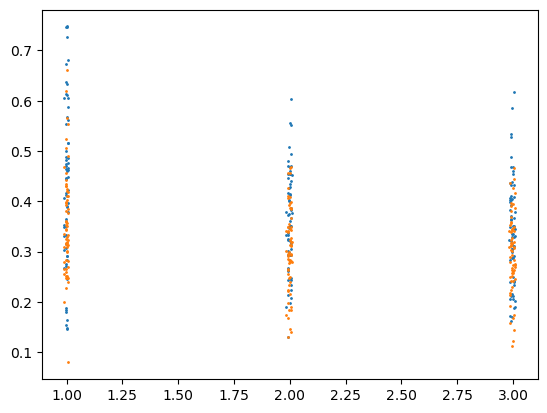

In [11]:
plt.plot(bvals_100206_sub_no_b5, normalized_scan_100206_sub_no_b5[42,:], "o", markersize = 1)
plt.plot(bvals_100610_sub_no_b5, normalized_scan_100610_sub_no_b5[42,:], "o", markersize = 1)

In [12]:
n_100206_all = np.loadtxt(config.data_folder2 + '/100206/bvecs')

n_100610_all = np.loadtxt(config.data_folder2 + '/100610/bvecs')

In [13]:
n_100206_sub = n_100206_all[:, rand_sub_bval_indice_100206]
n_100206_sub_no_b5 = n_100206_sub[:,big_b_indice_100206_sub].T
print(n_100206_sub_no_b5.shape)

b_values_100206_sub_no_b5 = torch.FloatTensor(bvals_100206_sub_no_b5)
gradient_directions_100206_sub_no_b5 = torch.FloatTensor(n_100206_sub_no_b5)

n_100610_sub = n_100610_all[:, rand_sub_bval_indice_100206]
n_100610_sub_no_b5 = n_100610_sub[:,big_b_indice_100610_sub].T
print(n_100610_sub_no_b5.shape)

b_values_100610_sub_no_b5 = torch.FloatTensor(bvals_100610_sub_no_b5)
gradient_directions_100610_sub_no_b5 = torch.FloatTensor(n_100610_sub_no_b5)

(195, 3)
(195, 3)


In [14]:
batch_size = 128
num_batches = len(normalized_scan_100206_sub_no_b5) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(normalized_scan_100206_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [15]:
batch_size = 128
val_num_batches = len(normalized_scan_100610_sub_no_b5) // batch_size
valloader = utils.DataLoader(torch.from_numpy(normalized_scan_100610_sub_no_b5.astype(np.float32)),
                            batch_size = batch_size, 
                            shuffle = True,
                            num_workers = 2,
                            drop_last = True)

In [16]:
val_set = torch.from_numpy(normalized_scan_100610_sub_no_b5.astype(np.float32))
print(val_set.shape)
print(type(val_set))

torch.Size([880154, 195])
<class 'torch.Tensor'>


In [17]:
bvals_num = len(b_values_100206_sub_no_b5)
net = network.BallStickNet(bvals_num)

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.00001)

In [18]:
train_loss_list=[]
avg_train_loss_list=[]

val_loss_list = []
avg_val_loss_list=[]

counter = 0

# Best loss
best_train_loss = 1e16
best_val_loss = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_train_loss = 0.
    
#     Training
    for i, X_batch in enumerate(tqdm(valloader), 0):
        optimizer.zero_grad()
        X_pred, theta, phi, mu_cart_pred, lambda_par_pred, lambda_iso_pred, volume_0_pred, volume_1_pred = net(X_batch, gradient_directions_100610_sub_no_b5, b_values_100610_sub_no_b5)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()
        
    train_loss_list.append(running_train_loss)
    avg_train_loss_list.append(running_train_loss/num_batches)
    print("Loss: {}; Average Loss: {}".format(running_train_loss, running_train_loss/num_batches))
    
#     Validation
    # net.eval()
    # running_val_loss = 0.
    # with torch.no_grad():
    #     val_pred, _, _, _, _, _, _, _ = net(val_set, gradient_directions_100610_sub_no_b5, b_values_100610_sub_no_b5)
    #     val_loss = criterion(val_pred.type(torch.FloatTensor), val_set.type(torch.FloatTensor))
    #     running_val_loss += val_loss.item()
    # val_loss_list.append(running_val_loss)
    # print("Validation Loss: {}".format(running_val_loss))
    
    net.eval()
    running_val_loss = 0.
    with torch.no_grad():
        for i, val_batch in enumerate(tqdm(trainloader), 0):
            val_pred, _, _, _, _, _, _, _ = net(val_batch,gradient_directions_100206_sub_no_b5, b_values_100206_sub_no_b5)
            val_loss = criterion(val_pred.type(torch.FloatTensor), val_batch.type(torch.FloatTensor))
            running_val_loss += val_loss.item()
    val_loss_list.append(running_val_loss)
    avg_val_loss_list.append(running_val_loss/val_num_batches)
    print("Val Loss: {}; Average Val Loss: {}".format(running_val_loss, running_val_loss/val_num_batches))
            

    # if running_train_loss < best_train_loss and running_val_loss < best_val_loss:
    if running_train_loss < best_train_loss:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best_train_loss = running_train_loss
        # best_val_loss = running_val_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best training loss: {}; best validation loss: {}".format(best_train_loss, best_val_loss))
            break
    counter += 1

print("Done") 
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6876/6876 [00:50<00:00, 135.88it/s]


Loss: 986.1289920308627; Average Loss: 0.13493828571850885


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 299.43it/s]


Val Loss: 434.91160061815754; Average Val Loss: 0.06325066908350167
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6876/6876 [00:48<00:00, 140.80it/s]


Loss: 913.3545670723543; Average Loss: 0.12498009948992259


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:22<00:00, 328.13it/s]


Val Loss: 430.17666443716735; Average Val Loss: 0.06256205125613254
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6876/6876 [00:49<00:00, 138.14it/s]


Loss: 911.403254004661; Average Loss: 0.12471308894426122


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:20<00:00, 350.34it/s]


Val Loss: 425.06381964636967; Average Val Loss: 0.06181847289795952
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6876/6876 [00:50<00:00, 137.40it/s]


Loss: 909.7920620874502; Average Loss: 0.1244926193332581


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:21<00:00, 337.33it/s]


Val Loss: 426.4405344375409; Average Val Loss: 0.06201869319917698
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6876/6876 [01:10<00:00, 97.12it/s]


Loss: 909.1627497361042; Average Loss: 0.12440650653203396


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:27<00:00, 262.68it/s]


Val Loss: 431.86366687715054; Average Val Loss: 0.06280739774245936
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6876/6876 [01:03<00:00, 107.72it/s]


Loss: 907.9080410497263; Average Loss: 0.12423481678294011


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 210.19it/s]


Val Loss: 437.4116437747143; Average Val Loss: 0.06361425883867282
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6876/6876 [01:15<00:00, 90.74it/s]


Loss: 907.4018243998289; Average Loss: 0.12416554794743143


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:34<00:00, 214.30it/s]


Val Loss: 439.36917139263824; Average Val Loss: 0.06389894871911551
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6876/6876 [02:04<00:00, 55.02it/s]


Loss: 908.2643851237372; Average Loss: 0.12428357760313864


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 196.43it/s]


Val Loss: 438.8842948358506; Average Val Loss: 0.06382843147699979
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6876/6876 [01:08<00:00, 99.95it/s]


Loss: 908.2766890684143; Average Loss: 0.12428526122994174


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:28<00:00, 253.14it/s]


Val Loss: 443.89297723351046; Average Val Loss: 0.06455686114507132
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 2


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6876/6876 [01:08<00:00, 100.68it/s]


Loss: 907.9327153423801; Average Loss: 0.12423819312293105


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:37<00:00, 193.68it/s]


Val Loss: 444.05488510942087; Average Val Loss: 0.06458040795657663
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 3


  1%|██▎                                                                                                                                                            | 101/6876 [00:08<03:05, 36.56it/s]

X_batch: 
torch.Size([128, 195])
tensor([[0.3238, 0.1996, 0.0738,  ..., 0.3616, 0.1670, 0.2000],
        [0.4638, 0.2499, 0.2101,  ..., 0.3277, 0.1379, 0.2307],
        [0.3125, 0.2560, 0.3143,  ..., 0.2268, 0.3279, 0.2443],
        ...,
        [0.4497, 0.2710, 0.2523,  ..., 0.4384, 0.2413, 0.3491],
        [0.5326, 0.2368, 0.2574,  ..., 0.5960, 0.1452, 0.3163],
        [0.1326, 0.1503, 0.1229,  ..., 0.1165, 0.1204, 0.0829]])
X_pred: 
torch.Size([128, 195])
tensor([[0.4114, 0.2051, 0.1142,  ..., 0.4042, 0.1230, 0.2002],
        [0.4623, 0.2691, 0.1683,  ..., 0.4513, 0.1837, 0.2611],
        [0.4792, 0.3177, 0.2206,  ..., 0.4634, 0.2437, 0.3068],
        ...,
        [0.4942, 0.3185, 0.2153,  ..., 0.4796, 0.2352, 0.3101],
        [0.3825, 0.2291, 0.1561,  ..., 0.3707, 0.1728, 0.2210],
        [0.1720, 0.0993, 0.0747,  ..., 0.1657, 0.0833, 0.0952]],
       grad_fn=<AddBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6876/6876 [01:35<00:00, 71.75it/s]


Loss: 907.2959090657532; Average Loss: 0.12415105488037127


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:26<00:00, 277.82it/s]


Val Loss: 447.9765973864123; Average Val Loss: 0.06515075587353292
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6876/6876 [01:22<00:00, 83.11it/s]


Loss: 906.6991900522262; Average Loss: 0.12406940203232433


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:24<00:00, 300.61it/s]


Val Loss: 450.9409294105135; Average Val Loss: 0.06558186873334984
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6876/6876 [01:14<00:00, 92.59it/s]


Loss: 906.050570844207; Average Loss: 0.12398064735142406


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:31<00:00, 229.15it/s]


Val Loss: 456.09209771081805; Average Val Loss: 0.06633102060948488
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 13; Bad epochs: 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6876/6876 [01:09<00:00, 99.58it/s]


Loss: 907.1238791602664; Average Loss: 0.12412751493709173


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7308/7308 [00:30<00:00, 239.80it/s]


Val Loss: 460.74111652653664; Average Val Loss: 0.06700714318303325
-----------------------------------------------------------------
Epoch: 14; Bad epochs: 1


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                           | 4300/6876 [00:44<00:26, 96.66it/s]


KeyboardInterrupt: 

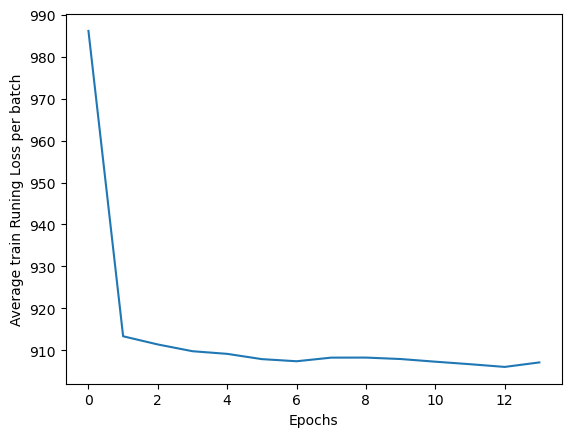

In [42]:
epoch_arr = np.arange(0, len(train_loss_list))
loss_arr = np.array(train_loss_list)
plt.plot(train_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average train Runing Loss per batch")
plt.show()

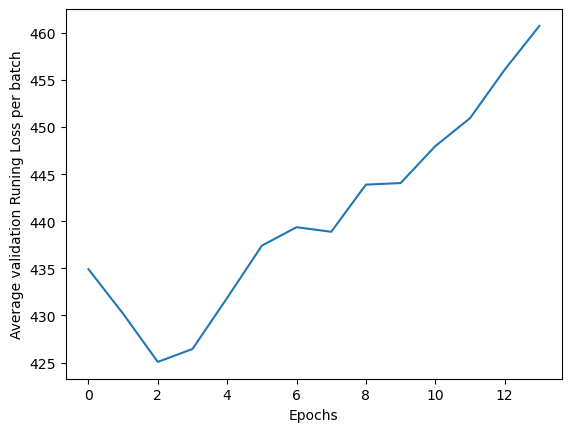

In [43]:
epoch_arr = np.arange(0, len(val_loss_list))
loss_arr = np.array(val_loss_list)
plt.plot(val_loss_list)
plt.xlabel("Epochs")
plt.ylabel("Average validation Runing Loss per batch")
plt.show()

In [28]:
torch.save(final_model, 'temp.pt')

In [21]:
normalized_scan_100307_full = np.load(config.norm_data_path + '/normalized_scan_100307_full.npy')

In [22]:
bvals_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvals')

In [23]:
bvals_100307_selected = bvals_all_100307[rand_sub_bval_indice_100206]*1e-3

In [24]:
normalized_scan_100307_sub = normalized_scan_100307_full[:,rand_sub_bval_indice_100206]

In [29]:
big_b_bvals_100307_selected = np.where(bvals_100307_selected != 0.005)[0]

In [30]:
normalized_scan_100307_sub_no_b5 = normalized_scan_100307_sub[:, big_b_bvals_100307_selected]
bvals_100307_selected_no_5 = bvals_100307_selected[big_b_bvals_100307_selected]

In [32]:
n_all_100307 = np.loadtxt(config.data_folder2 + '/100307/bvecs')
n_100307_sub = n_all_100307[:,rand_sub_bval_indice_100206]
n_100307_sub_no_b5 = n_100307_sub[:,big_b_bvals_100307_selected].T
print(n_100307_sub_no_b5.shape)

b_values_100307_sub = torch.FloatTensor(bvals_100307_selected_no_5)
gradient_directions_100307_sub = torch.FloatTensor(n_100307_sub_no_b5)

(195, 3)


In [34]:
net = network.BallStickNet(len(b_values_100307_sub))
net.load_state_dict(torch.load("/Users/weiwenhua/UGY4/COMP0029/COMP0029-Project/deep-BAS-subsets/temp.pt"))
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=195, out_features=195, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=195, out_features=195, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=195, out_features=195, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=195, out_features=195, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=195, out_features=195, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=195, out_features=195, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=195, out_features=5, bias=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

In [36]:
X_100307_pred, theta_100307_pred, phi_100307_pred, mu_cart_100307_pred, lambda_par_100307_pred, lambda_iso_100307_pred,  volume_0_100307_pred, volume_1_100307_pred = net(torch.from_numpy(normalized_scan_100307_sub_no_b5.astype(np.float32)),gradient_directions_100307_sub,b_values_100307_sub)

In [38]:
scan_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/data.nii.gz')
mask_100307 = process_data.get_nifti_data(config.data_folder2 + '/100307/nodif_brain_mask.nii.gz')
mask_100307_long_pro = process_data.get_mask_pro(scan_100307, mask_100307)

In [40]:
import matplotlib

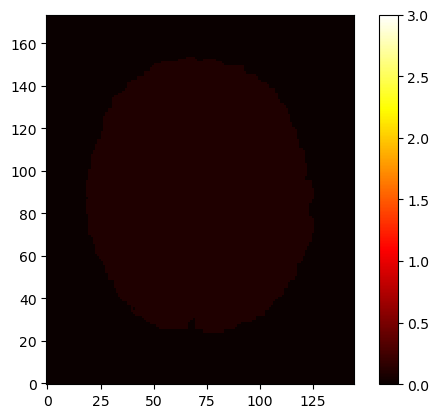

In [41]:
lambda_par_100307_pred_3d = process_data.back_to_3D(mask_100307_long_pro, lambda_par_100307_pred, (145, 174, 145))
im = plt.imshow(lambda_par_100307_pred_3d[:,:,70].squeeze().T, origin='lower', interpolation='nearest', cmap=matplotlib.colormaps["hot"], vmin = 0, vmax = 3)
plt.colorbar(im)

In [3]:
scan_100610 = process_data.get_nifti_data(config.data_folder2 + '/100610/data.nii.gz')
mask_100610 = process_data.get_nifti_data(config.data_folder2 + '/100610/nodif_brain_mask.nii.gz')
scan_dimension = scan_100610.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [4]:
scan_100610_long = np.reshape(scan_100610, (x*y*z, b))

mask_100610_long = np.reshape(mask_100610, (x*y*z, 1))

In [5]:
indices_beginning_0_all = np.where(scan_100610_long[:, 0] == 0)[0]
print(len(indices_beginning_0_all))

2313337


In [6]:
mask_100610_long_pro = np.copy(mask_100610_long)
mask_100610_long_pro[indices_beginning_0_all] = 0

print(len(np.where(mask_100610_long_pro == 0)[0]))

2778196


In [7]:
scan_100610_long_no_background = process_data.remove_background(scan_100610_long, mask_100610_long_pro)

In [8]:
bvals_all_100610 = np.loadtxt(config.data_folder2 + '/100610/bvals') * 1e-3

In [9]:
S0_100610 = process_data.get_S0(scan_100610_long_no_background, bvals_all_100610)

In [11]:
normalized_scan_100610_full = scan_100610_long_no_background / S0_100610

In [14]:
np.save("normalized_scan_100610_full.npy",normalized_scan_100610_full)